In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.preprocessing import LabelBinarizer
import os
import time
import sys
import numpy as np
sys.path.append('/home/chaofan/powerknowledge/data')
# sys.path.append('data/')
from read_PLAID_data import read_processed_data,get_feature_name

In [2]:
# 读取old数据，除掉笔记本和台灯
start_reading_time = time.time()
feature_select = [
    'i_mean', 'i_wave_factor', 'i_pp_rms', 'i_thd', 'pure_thd', 'P', 'Q',
    'P_F', 'i_hp1', 'z_hp1', 'i_hm2', 'z_hm2', 'i_hp2', 'z_hp2', 'i_hm3',
    'z_hm3', 'i_hp3', 'z_hp3', 'i_hm4', 'z_hm4', 'i_hp4', 'z_hp4', 'i_hm5',
    'z_hm5', 'i_hp5', 'z_hp5', 'i_hm6', 'z_hm6', 'i_hp6', 'z_hp6', 'i_hm7',
    'z_hm7', 'i_hp7', 'z_hp7'
]
selected_label = [
    'Air Conditioner', 'Blender', 'Coffee maker', 'Fan', 'Fridge', 'Hair Iron',
    'Hairdryer', 'Heater', 'Incandescent Light Bulb', 'Microwave',
    'Soldering Iron', 'Vacuum', 'Washing Machine', 'Water kettle'
]
x_mh_train, y_mh_train, mh_index_train = read_processed_data(
    'type',
    type_header='appliance',
    selected_label=selected_label,
    direaction=1,
    offset=0,
    each_lenth=10,
    feature_select=feature_select,
    source='submetered_process2.1/training')

x_mh_validation, y_mh_validation, mh_index_validation = read_processed_data(
    'type',
    type_header='appliance',
    selected_label=selected_label,
    direaction=1,
    offset=0,
    each_lenth=10,
    feature_select=feature_select,
    source='submetered_process2.1/validation')

x_mh_trainval = np.concatenate((x_mh_train, x_mh_validation), axis=0)
y_mh_trainval = np.concatenate((y_mh_train, y_mh_validation), axis=0)

x_mh_test, y_mh_test, mh_index_test = read_processed_data(
    'type',
    type_header='appliance',
    selected_label=selected_label,
    direaction=1,
    offset=0,
    each_lenth=10,
    feature_select=feature_select,
    source='submetered_process2.1/testing')
print('finished loading data, cost %.3fs' % (time.time() - start_reading_time))

finished loading data, cost 11.272s


In [9]:
rf0 = RandomForestClassifier(oob_score=True, random_state=10)
rf0.fit(x_mh_train, y_mh_train)
print(rf0.oob_score_)
print(rf0.score(x_mh_validation, y_mh_validation))


0.9992424242424243
0.8346341463414634


In [5]:
# 网格搜索弱学习器个数
best_score = 0.0
for n_estimator in range(10, 201, 10):
    estimator = RandomForestClassifier(n_estimators=n_estimator,
                                        min_samples_split=10,
                                        min_samples_leaf=5,
                                        max_depth=8,
                                        max_features='sqrt',
                                        random_state=10)
    estimator.fit(x_mh_train, y_mh_train)
    score = estimator.score(x_mh_validation, y_mh_validation)
    if score > best_score:
        best_score = score
        best_n_estimator = n_estimator
gbc0 = RandomForestClassifier(n_estimators=best_n_estimator,
                                min_samples_split=10,
                                min_samples_leaf=5,
                                max_depth=8,
                                max_features='sqrt',
                                random_state=10)
gbc0.fit(x_mh_trainval, y_mh_trainval)
y_trainval_pred = gbc0.predict(x_mh_trainval)
y_trainval_predprob = gbc0.predict_proba(x_mh_trainval)
y_trainval_one_hot = LabelBinarizer().fit_transform(y_mh_trainval)
y_test_pred = gbc0.predict(x_mh_test)
y_test_predprob = gbc0.predict_proba(x_mh_test)
y_test_one_hot = LabelBinarizer().fit_transform(y_mh_test)
print("train best score: %f" % best_score)
print("Accuracy : %.4g" % metrics.accuracy_score(y_mh_test, y_test_pred))
print("AUC Score (train): %f" %
      metrics.roc_auc_score(y_trainval_one_hot, y_trainval_predprob, average='micro'))
print("AUC Score (test): %f" %
      metrics.roc_auc_score(y_test_one_hot, y_test_predprob, average='micro'))
print('best_n_estimator: %02d' % best_n_estimator)

/home/chaofan/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/chaofan/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:544: RuntimeWarning: invalid value encountered in true_divide
  decision = (predictions[k] /
/home/chaofan/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/chaofan/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:544: RuntimeWarning: invalid value encountered in true_divide
  decision = (predictions[k] /
train best score: 0.797073
Accuracy : 0.8021
AUC Score (train): 0.999957
AUC Score (test): 0.988156
best_n_estimator: 200


In [2]:
# 测试曾老师特征
start_reading_time = time.time()
feature_select=get_feature_name('/home/chaofan/powerknowledge/data/source/submetered_zengj/total')
selected_label = [
    'Air Conditioner', 'Blender', 'Coffee maker', 'Fan', 'Fridge', 'Hair Iron',
    'Hairdryer', 'Heater', 'Incandescent Light Bulb', 'Microwave',
    'Soldering Iron', 'Vacuum', 'Washing Machine', 'Water kettle'
]
x_mh_train, y_mh_train, mh_index_train = read_processed_data(
    'type',
    type_header='appliance',
    selected_label=selected_label,
    direaction=1,
    offset=0,
    each_lenth=1,
    feature_select=feature_select,
    source='submetered_zengj/training')

x_mh_validation, y_mh_validation, mh_index_validation = read_processed_data(
    'type',
    type_header='appliance',
    selected_label=selected_label,
    direaction=1,
    offset=0,
    each_lenth=1,
    feature_select=feature_select,
    source='submetered_zengj/validation')

x_mh_trainval = np.concatenate((x_mh_train, x_mh_validation), axis=0)
y_mh_trainval = np.concatenate((y_mh_train, y_mh_validation), axis=0)

x_mh_test, y_mh_test, mh_index_test = read_processed_data(
    'type',
    type_header='appliance',
    selected_label=selected_label,
    direaction=1,
    offset=0,
    each_lenth=1,
    feature_select=feature_select,
    source='submetered_zengj/testing')
print('finished loading data, cost %.3fs' % (time.time() - start_reading_time))

finished loading data, cost 4.971s


In [16]:
# 全部样本一起训练识别
rf = RandomForestClassifier(n_estimators=200,
                                min_samples_split=10,
                                min_samples_leaf=5,
                                max_depth=8,
                                max_features='sqrt',
                                random_state=10)
rf.fit(x_mh_trainval, y_mh_trainval)
y_trainval_pred = rf.predict(x_mh_trainval)
y_trainval_predprob = rf.predict_proba(x_mh_trainval)
y_trainval_one_hot = LabelBinarizer().fit_transform(y_mh_trainval)
y_test_pred = rf.predict(x_mh_test)
y_test_predprob = rf.predict_proba(x_mh_test)
y_test_one_hot = LabelBinarizer().fit_transform(y_mh_test)

print("Accuracy : %.4g" % metrics.accuracy_score(y_mh_test, y_test_pred))

print("AUC Score (test): %f" %
      metrics.roc_auc_score(y_test_one_hot, y_test_predprob, average='micro'))


Accuracy : 0.8083
AUC Score (test): 0.979803


In [17]:
# 转成C code
from sklearn.tree import _tree
class_num=len(selected_label)

def forest_to_code(forest, feature_names, output_file):
    with open(output_file, 'a+') as f:
        parameters = "("
        for idx, value in enumerate(feature_names):
            if idx != 0:
                parameters += ','
            parameters += "float" + " " + str(value)
        parameters += ")"
        f.write("float *tree" + parameters + "\n")
        f.write("{\n")
        f.write("    static float r[{}] = {{0}};\n".format(class_num))
        f.close()

    for idx, estimator in enumerate(forest.estimators_):
        with open(output_file, 'a+') as f:
            f.write("    // No.{} tree\n".format(idx))
            f.close()

        tree_ = estimator.tree_
        feature_name = [
            feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
            for i in tree_.feature
        ]

        # tree内部的节点编号规则为，先左后右，先纵后横，depth只是用来计算缩进值
        def recurse(node, depth):
            indent = "    " * depth
            if tree_.feature[node] != _tree.TREE_UNDEFINED:
                # 树枝节点
                name = feature_name[node]
                threshold = tree_.threshold[node]
                with open(output_file, 'a+') as f:
                    f.write("{}if ({} <= {})\n".format(indent, name,
                                                       round(threshold, 3)))
                    f.write("{}".format(indent) + "{\n")
                    f.close()
                recurse(tree_.children_left[node], depth + 1)
                with open(output_file, 'a+') as f:
                    f.write("{}".format(indent) + "}\n")
                    f.close()
                # children_left为当前节点的左子节点编号
                with open(output_file, 'a+') as f:
                    f.write("{}else\n".format(indent))
                    f.write("{}".format(indent) + "{\n")
                    f.close()
                recurse(tree_.children_right[node], depth + 1)
                # children_right为当前节点的右子节点编号
                with open(output_file, 'a+') as f:
                    f.write("{}".format(indent) + "}\n")
                    f.close()
            else:
                # 叶子节点
                with open(output_file, 'a+') as f:
                    s = '{'
                    for idx, value in enumerate(tree_.value[node][0]):
                        if idx != 0:
                            s += ','
                        s += str(value)
                    s += '}'
                    f.write("{}float o[] = ".format(indent) + s + ';\n')
                    f.write('{}arrayplus(r,o);\n'.format(indent))
                    f.close()

        recurse(0, 1)

    with open(output_file, 'a+') as f:
        f.write("return r;\n")
        f.write("}\n")
        f.close()

forest_to_code(rf,feature_select,"/home/chaofan/powerknowledge/model/deep_learning_model/test_tree.txt")   


In [2]:
# test diandongche
start_reading_time = time.time()
feature_select=get_feature_name('/home/chaofan/powerknowledge/data/source/submetered_zengj/total')

x_mh_train, y_mh_train, mh_index_train = read_processed_data(
    'type',
    type_header='appliance',
    direaction=1,
    offset=0,
    each_lenth=100,
    feature_select=feature_select,
    source='HIOKI/try',
    source_json='/home/chaofan/powerknowledge/data/source/HIOKI/try.json')

x_mh_test, y_mh_test, mh_index_test = read_processed_data(
    'type',
    type_header='appliance',
    direaction=0,
    offset=0,
    each_lenth=120,
    feature_select=feature_select,
    source='HIOKI/powerfingerprint_process',
    source_json='/home/chaofan/powerknowledge/data/source/HIOKI/powerfingerprint.json')
print('finished loading data, cost %.3fs' % (time.time() - start_reading_time))

finished loading data, cost 1.459s


In [4]:
# diandongche
best_score = 0.0
for n_estimator in range(10, 201, 10):
    estimator = RandomForestClassifier(n_estimators=n_estimator,
                                        min_samples_split=10,
                                        min_samples_leaf=5,
                                        max_depth=8,
                                        max_features='sqrt',
                                        random_state=10)
    estimator.fit(x_mh_train, y_mh_train)
    score = estimator.score(x_mh_train, y_mh_train)
    if score > best_score:
        best_score = score
        best_n_estimator = n_estimator
gbc0 = RandomForestClassifier(n_estimators=best_n_estimator,
                                min_samples_split=10,
                                min_samples_leaf=5,
                                max_depth=8,
                                max_features='sqrt',
                                random_state=10)
gbc0.fit(x_mh_train, y_mh_train)

y_test_pred = gbc0.predict(x_mh_test)

print("train best score: %f" % best_score)
print("Accuracy : %.4g" % metrics.accuracy_score(y_mh_test, y_test_pred))
print('best_n_estimator: %02d' % best_n_estimator)

train best score: 1.000000
Accuracy : 0.95
best_n_estimator: 20


In [4]:
# HIOKI
from read_HIOKI_data import read_processed_data
selected_label=['Fan','Hair Dryer','Kettle']
test_x,test_y=read_processed_data('type',selected_label=selected_label,direaction=1,each_lenth=1)
test_y=test_y.reshape(-1,1)
pred_y = gbc0.predict(test_x).reshape(-1,1)
plot_y=np.concatenate((test_y,pred_y),axis=1)

In [12]:
# test zengj dianzi
start_reading_time = time.time()
feature_select=get_feature_name('/home/chaofan/powerknowledge/data/source/submetered_zengj/total')
selected_label = [
    'Laptop','Compact Fluorescent Lamp'
]
x_electric_train, y_electric_train, electric_index_train = read_processed_data(
    'type',
    type_header='appliance',
    selected_label=selected_label,
    direaction=1,
    offset=0,
    each_lenth=1,
    feature_select=feature_select,
    source='submetered_zengj/training')

x_electric_validation, y_electric_validation, electric_index_validation = read_processed_data(
    'type',
    type_header='appliance',
    selected_label=selected_label,
    direaction=1,
    offset=0,
    each_lenth=1,
    feature_select=feature_select,
    source='submetered_zengj/validation')

x_electric_trainval = np.concatenate((x_electric_train, x_electric_validation), axis=0)
y_electric_trainval = np.concatenate((y_electric_train, y_electric_validation), axis=0)

x_electric_test, y_electric_test, electric_index_test = read_processed_data(
    'type',
    type_header='appliance',
    selected_label=selected_label,
    direaction=1,
    offset=0,
    each_lenth=1,
    feature_select=feature_select,
    source='submetered_zengj/testing')
print('finished loading data, cost %.3fs' % (time.time() - start_reading_time))

rf_electric = RandomForestClassifier(n_estimators=200,
                                    min_samples_split=10,
                                    min_samples_leaf=5,
                                    max_depth=8,
                                    max_features='sqrt',
                                    random_state=10)
rf_electric.fit(x_electric_trainval, y_electric_trainval)

y_test_pred = rf_electric.predict(x_electric_test)
y_test_predprob = rf_electric.predict_proba(x_electric_test)
y_test_one_hot = LabelBinarizer().fit_transform(y_electric_test)

print("Accuracy : %.4g" % metrics.accuracy_score(y_electric_test, y_test_pred))

# print("AUC Score (test): %f" %
#       metrics.roc_auc_score(y_test_one_hot, y_test_predprob, average='micro'))


finished loading data, cost 4.715s
Accuracy : 0.9925


In [4]:
# HIOKI
from read_HIOKI_data import read_processed_data
selected_label=['Incandescent Lamp','Table Lamp']
test_x,test_y=read_processed_data('type',selected_label=selected_label,direaction=1,each_lenth=1)
test_y=test_y.reshape(-1,1)
pred_y = rf_electric.predict(test_x).reshape(-1,1)
plot_y=np.concatenate((test_y,pred_y),axis=1)

In [8]:
# 以下为分大小功率进行 小功率
start_reading_time = time.time()
feature_select=get_feature_name('/home/chaofan/powerknowledge/data/source/submetered_zengj/total')
selected_label = [
     'Fan', 'Fridge', 'Hair Iron',
    'Incandescent Light Bulb'
]
x_low_train, y_low_train, low_index_train = read_processed_data(
    'type',
    type_header='appliance',
    selected_label=selected_label,
    direaction=1,
    offset=0,
    each_lenth=1,
    feature_select=feature_select,
    source='submetered_zengj/training')

x_low_validation, y_low_validation, low_index_validation = read_processed_data(
    'type',
    type_header='appliance',
    selected_label=selected_label,
    direaction=1,
    offset=0,
    each_lenth=1,
    feature_select=feature_select,
    source='submetered_zengj/validation')

x_low_trainval = np.concatenate((x_low_train, x_low_validation), axis=0)
y_low_trainval = np.concatenate((y_low_train, y_low_validation), axis=0)

x_low_test, y_low_test, low_index_test = read_processed_data(
    'type',
    type_header='appliance',
    selected_label=selected_label,
    direaction=1,
    offset=0,
    each_lenth=1,
    feature_select=feature_select,
    source='submetered_zengj/testing')
print('finished loading data, cost %.3fs' % (time.time() - start_reading_time))

rf_low = RandomForestClassifier(n_estimators=150,
                                min_samples_split=10,
                                min_samples_leaf=5,
                                max_depth=8,
                                max_features='sqrt',
                                random_state=10)
rf_low.fit(x_low_trainval, y_low_trainval)
y_trainval_pred = rf_low.predict(x_low_trainval)
y_trainval_predprob = rf_low.predict_proba(x_low_trainval)
y_trainval_one_hot = LabelBinarizer().fit_transform(y_low_trainval)
y_test_pred = rf_low.predict(x_low_test)
y_test_predprob = rf_low.predict_proba(x_low_test)
y_test_one_hot = LabelBinarizer().fit_transform(y_low_test)

print("Accuracy : %.4g" % metrics.accuracy_score(y_low_test, y_test_pred))

# print("AUC Score (test): %f" %
#       metrics.roc_auc_score(y_test_one_hot, y_test_predprob, average='micro'))

finished loading data, cost 4.804s
Accuracy : 0.98


In [8]:
from read_HIOKI_data import read_processed_data
selected_label=['Fan','Incandescent Lamp']
test_x,test_y=read_processed_data('type',selected_label=selected_label,direaction=1,each_lenth=1)
test_y=test_y.reshape(-1,1)
pred_y = gbc0.predict(test_x).reshape(-1,1)
plot_y=np.concatenate((test_y,pred_y),axis=1)

In [10]:
# 大功率
start_reading_time = time.time()
feature_select=get_feature_name('/home/chaofan/powerknowledge/data/source/submetered_zengj/total')
selected_label = [
    'Air Conditioner', 'Blender', 'Coffee maker',
    'Hairdryer', 'Heater', 'Microwave',
    'Soldering Iron', 'Vacuum', 'Washing Machine', 'Water kettle'
]
x_high_train, y_high_train, high_index_train = read_processed_data(
    'type',
    type_header='appliance',
    selected_label=selected_label,
    direaction=1,
    offset=0,
    each_lenth=1,
    feature_select=feature_select,
    source='submetered_zengj/training')

x_high_validation, y_high_validation, high_index_validation = read_processed_data(
    'type',
    type_header='appliance',
    selected_label=selected_label,
    direaction=1,
    offset=0,
    each_lenth=1,
    feature_select=feature_select,
    source='submetered_zengj/validation')

x_high_trainval = np.concatenate((x_high_train, x_high_validation), axis=0)
y_high_trainval = np.concatenate((y_high_train, y_high_validation), axis=0)

x_high_test, y_high_test, high_index_test = read_processed_data(
    'type',
    type_header='appliance',
    selected_label=selected_label,
    direaction=1,
    offset=0,
    each_lenth=1,
    feature_select=feature_select,
    source='submetered_zengj/testing')
print('finished loading data, cost %.3fs' % (time.time() - start_reading_time))

rf_high = RandomForestClassifier(n_estimators=150,
                                min_samples_split=10,
                                min_samples_leaf=5,
                                max_depth=8,
                                max_features='sqrt',
                                random_state=10)
rf_high.fit(x_high_trainval, y_high_trainval)
y_trainval_pred = rf_high.predict(x_high_trainval)
y_trainval_predprob = rf_high.predict_proba(x_high_trainval)
y_trainval_one_hot = LabelBinarizer().fit_transform(y_high_trainval)
y_test_pred = rf_high.predict(x_high_test)
y_test_predprob = rf_high.predict_proba(x_high_test)
y_test_one_hot = LabelBinarizer().fit_transform(y_high_test)

print("Accuracy : %.4g" % metrics.accuracy_score(y_high_test, y_test_pred))

# print("AUC Score (test): %f" %
#       metrics.roc_auc_score(y_test_one_hot, y_test_predprob, average='micro'))

finished loading data, cost 5.171s
Accuracy : 0.8857


In [32]:
def total_clf(x_test,prob_threshold=0.6,rate=0.9):
    test_pred=[]
    for data in x_test:
        data=data.reshape(1,-1)
        data_prob_list=[]
        data_pred_list=[]
        data_prob_list.append(np.max(rf_electric.predict_proba(data)))
        data_pred_list.append(rf_electric.predict(data))
        data_prob_list.append(np.max(rf_low.predict_proba(data)))
        data_pred_list.append(rf_low.predict(data))
        data_prob_list.append(np.max(rf_high.predict_proba(data)))
        data_pred_list.append(rf_high.predict(data))
        if data[0,4]>4.2:
            if data_prob_list[0]>prob_threshold:
                test_pred.append(data_pred_list[0])
                continue
            elif data[0,7]<200:
                if data_prob_list[1]>prob_threshold*rate:
                    test_pred.append(data_pred_list[1])
                    continue
                else:
                    if data_prob_list[2]>prob_threshold*rate*rate:
                        test_pred.append(data_pred_list[2])
                        continue
                    else:
                        test_pred.append(data_pred_list[np.argmax(data_prob_list)])
                        continue
        elif data[0,7]<200:
            if data_prob_list[1]>prob_threshold:
                    test_pred.append(data_pred_list[1])
                    continue
            else:
                if data_prob_list[2]>prob_threshold*rate:
                    test_pred.append(data_pred_list[2])
                    continue
                else:
                    if data_prob_list[0]>prob_threshold*rate*rate:
                        test_pred.append(data_pred_list[0])
                        continue
                    else:
                        test_pred.append(data_pred_list[np.argmax(data_prob_list)])
                        continue
        elif data[0,7]>=200:
            if data_prob_list[2]>prob_threshold:
                test_pred.append(data_pred_list[2])
                continue
            else:
                if data_prob_list[1]>prob_threshold*rate:
                    test_pred.append(data_pred_list[1])
                    continue
                else:
                    if data_prob_list[0]>prob_threshold*rate*rate:
                        test_pred.append(data_pred_list[0])
                        continue
                    else:
                        test_pred.append(data_pred_list[np.argmax(data_prob_list)])
                        continue
    return test_pred

def calc_acc(labels,predictions):
    counts=0
    if len(labels)!=len(predictions):
        return 0
    else:
        for i,pred in enumerate(predictions):
            if pred==labels[i]:
                counts+=1
        return counts/len(predictions)

x_test = np.concatenate((x_electric_test, x_low_test, x_high_test), axis=0)
y_test = np.concatenate((y_electric_test, y_low_test, y_high_test), axis=0)

for threshold in [0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9]:
    preds=np.array(total_clf(x_test,threshold))
    preds=preds.reshape(len(preds),)
    print("thre:%f,calc:%.3f" %(threshold,calc_acc(y_test,preds)))



thre:0.400000,calc:0.729
thre:0.450000,calc:0.729
thre:0.500000,calc:0.715
thre:0.550000,calc:0.706
thre:0.600000,calc:0.693
thre:0.650000,calc:0.660
thre:0.700000,calc:0.629
thre:0.750000,calc:0.603
thre:0.800000,calc:0.555
thre:0.850000,calc:0.530
thre:0.900000,calc:0.507


In [11]:
from read_HIOKI_data import read_processed_data
selected_label=['Hair Dryer','Kettle']
test_x,test_y=read_processed_data('type',selected_label=selected_label,direaction=1,each_lenth=1)
test_y=test_y.reshape(-1,1)
pred_y = gbc0.predict(test_x).reshape(-1,1)
plot_y=np.concatenate((test_y,pred_y),axis=1)

In [21]:
from read_HIOKI_data import read_processed_data
feature_select=get_feature_name('/home/chaofan/powerknowledge/data/source/submetered_zengj/total')
train_x,train_y=read_processed_data('type',direaction=1,each_lenth=10,source='/HIOKI_xinpei/process/high_power/train')
test_x,test_y=read_processed_data('type',direaction=1,each_lenth=10,source='/HIOKI_xinpei/process/high_power/test')

for n_estimator in range(10,201,10):
    gbc0 = RandomForestClassifier(n_estimators=n_estimator,
                                    min_samples_split=10,
                                    min_samples_leaf=5,
                                    max_depth=7,
                                    max_features='sqrt',
                                    random_state=10)
    gbc0.fit(train_x, train_y)
    y_test_pred = gbc0.predict(test_x)
    print("estimator: %03d  Accuracy : %.4g" % (n_estimator,metrics.accuracy_score(test_y, y_test_pred)))
y_plot=np.concatenate((test_y.reshape(-1,1),y_test_pred.reshape(-1,1)),axis=1)
# y_plot=np.concatenate((test_y.reshape(-1,1),y_test_pred.reshape(-1,1)),axis=1)
# print("Accuracy : %.4g" % metrics.accuracy_score(test_y, y_test_pred))


estimator: 010  Accuracy : 0.8
estimator: 020  Accuracy : 0.7947
estimator: 030  Accuracy : 0.8368
estimator: 040  Accuracy : 0.8316
estimator: 050  Accuracy : 0.8632
estimator: 060  Accuracy : 0.8526
estimator: 070  Accuracy : 0.8105
estimator: 080  Accuracy : 0.8211
estimator: 090  Accuracy : 0.8158
estimator: 100  Accuracy : 0.8
estimator: 110  Accuracy : 0.8
estimator: 120  Accuracy : 0.8368
estimator: 130  Accuracy : 0.8158
estimator: 140  Accuracy : 0.8211
estimator: 150  Accuracy : 0.8316
estimator: 160  Accuracy : 0.8421
estimator: 170  Accuracy : 0.8421
estimator: 180  Accuracy : 0.8421
estimator: 190  Accuracy : 0.8632
estimator: 200  Accuracy : 0.8579


In [22]:
from read_HIOKI_data import read_processed_data
feature_select=get_feature_name('/home/chaofan/powerknowledge/data/source/submetered_zengj/total')
train_x,train_y=read_processed_data('type',direaction=1,each_lenth=10,source='/HIOKI_xinpei/process/low_power/train')
test_x,test_y=read_processed_data('type',direaction=1,each_lenth=10,source='/HIOKI_xinpei/process/low_power/test')

for n_estimator in range(10,201,10):
    gbc0 = RandomForestClassifier(n_estimators=n_estimator,
                                    min_samples_split=10,
                                    min_samples_leaf=5,
                                    max_depth=7,
                                    max_features='sqrt',
                                    random_state=10)
    gbc0.fit(train_x, train_y)
    y_test_pred = gbc0.predict(test_x)
    print("estimator: %03d  Accuracy : %.4g" % (n_estimator,metrics.accuracy_score(test_y, y_test_pred)))
y_plot=np.concatenate((test_y.reshape(-1,1),y_test_pred.reshape(-1,1)),axis=1)


estimator: 010  Accuracy : 0.8909
estimator: 020  Accuracy : 0.9091
estimator: 030  Accuracy : 0.9091
estimator: 040  Accuracy : 0.9091
estimator: 050  Accuracy : 0.9091
estimator: 060  Accuracy : 0.9091
estimator: 070  Accuracy : 0.9091
estimator: 080  Accuracy : 0.9091
estimator: 090  Accuracy : 0.9091
estimator: 100  Accuracy : 0.9091
estimator: 110  Accuracy : 0.9091
estimator: 120  Accuracy : 0.9091
estimator: 130  Accuracy : 0.9091
estimator: 140  Accuracy : 0.9091
estimator: 150  Accuracy : 0.9091
estimator: 160  Accuracy : 0.9091
estimator: 170  Accuracy : 0.9091
estimator: 180  Accuracy : 0.9091
estimator: 190  Accuracy : 0.9091
estimator: 200  Accuracy : 0.9091


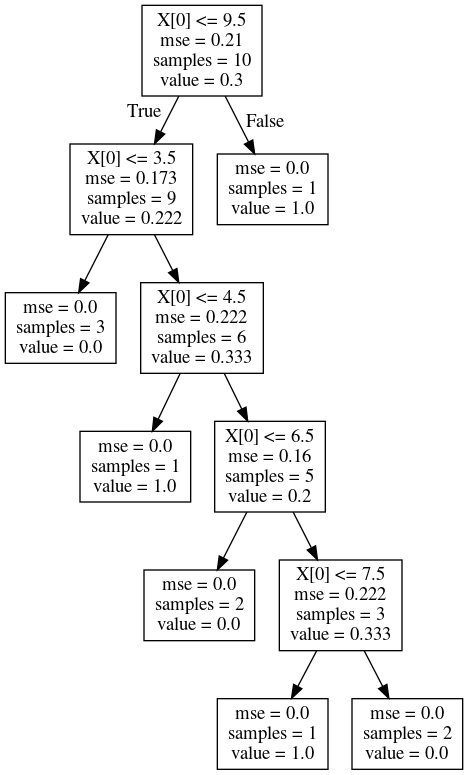

In [6]:
import numpy as np
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
import pydotplus
from IPython.display import Image, display
x=np.array([1,2,3,4,5,6,7,8,9,10]).reshape(-1,1)
y=np.array([0,0,0,1,0,0,1,0,0,1]).reshape(-1,1)
dtr=DecisionTreeRegressor()
dtr.fit(x,y)
dot_data=tree.export_graphviz(dtr)
graph = pydotplus.graph_from_dot_data(dot_data)
display(Image(graph.create_png()))
